In [5]:
import pulp
import matplotlib.pyplot as plt

In [7]:
# Define sets
years = [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030]
technologies = ['fossil', 'renewable']

# Define info
initial_capacity = {'fossil':5, 'renewable':0} # in GW
capacity_factor = {'fossil':0.8, 'renewable':0.18}
efficiency_fossil = 0.4
capex = {'fossil':700000000, 'renewable':800000000} # in $/GW
variable_opex = {'fossil':40000, 'renewable':0} # in $/GWh
fixed_opex = {'fossil':7000000, 'renewable':8000000} # in $/GW/year
land_use = {'fossil':0, 'renewable':10} # in km2/GW

operational_hours = 8760 # in hours
discount = 0.1
demand = {2020:7230, 2021:8000, 2022:9000, 2023:10000, 2024:12000, 2025:13000, 2026:15000, 2027:16000, 2028:16000, 2029:16000, 2030:16000} # in GWh

# Fuel costs in $/GWh_th
fossil_costs = {2020:15000, 2021:15000, 2022:15000, 2023:15000, 2024:15000, 2025:15000, 2026:15000, 2027:15000, 2028:15000, 2029:15000, 2030:15000}
fossil_emissions = 280 # tCO2/GWh_th

In [9]:
#Initialise model
model = pulp.LpProblem("Power_System", pulp.LpMinimize)

In [11]:
# Decision variables
new_capacity = pulp.LpVariable.dicts("New_Capacity", [(t,y) for t in technologies for y in years], lowBound=0, cat="Continuous") # in GW
cumulative_capacity = pulp.LpVariable.dicts("Cumulative_Capacity", [(t,y) for t in technologies for y in years], lowBound=0, cat="Continuous") # in GW
dispatch = pulp.LpVariable.dicts("Dispatch", [(t,y) for t in technologies for y in years], lowBound=0, cat="Continuous") # in GWh

In [13]:
# Optimisation objective
model += pulp.lpSum(new_capacity[(t,y)]*capex[t]/((1+discount)**(y-2020)) for t in technologies for y in years) + pulp.lpSum(dispatch[(t,y)]*variable_opex[t]/((1+discount)**(y-2020)) for t in technologies for y in years) + pulp.lpSum(cumulative_capacity[(t,y)]*fixed_opex[t]/((1+discount)**(y-2020)) for t in technologies for y in years) + pulp.lpSum(dispatch[('fossil',y)]/efficiency_fossil*fossil_costs[y]/((1+discount)**(y-2020)) for y in years)

# Cumulative capacity calc (Technically constraint)
for t in technologies:
    for i in range(0,len(years)):
        if i==0:
            model += cumulative_capacity[(t,years[i])]==initial_capacity[t] + new_capacity[(t,years[i])]
        else:
            model += cumulative_capacity[(t,years[i])]==cumulative_capacity[(t,years[i-1])] + new_capacity[(t,years[i])]

In [15]:
# Constraint 1: Supply = Demand
for y in years: 
    model += pulp.lpSum(dispatch[(t,y)] for t in technologies) == demand[y]

#Constraint 2: Max generation GWh <= Cumulative installed capacity * workign hours
for y in years: 
    for t in technologies: 
        model += dispatch[(t,y)] <= cumulative_capacity[(t,y)]*operational_hours*capacity_factor[t]

In [17]:
# Solve model
model.solve(pulp.PULP_CBC_CMD(msg=False))

1

In [19]:
print(pulp.LpStatus[model.status], '\n')
print(pulp.value(model.objective)/1000000)

for t in technologies:
    for y in years: 
        print(f"{t} new capacity in year {y} is ", pulp.value(new_capacity[(t,y)]), "  |  ", pulp.value(cumulative_capacity[(t,y)]))

print('\n')

for t in technologies:
    for y in years: 
        print(f"{t} dispatch in year {y} is ", pulp.value(dispatch[(t,y)]))

Optimal 

6595.443459086576
fossil new capacity in year 2020 is  0.0   |   5.0
fossil new capacity in year 2021 is  0.0   |   5.0
fossil new capacity in year 2022 is  0.0   |   5.0
fossil new capacity in year 2023 is  0.0   |   5.0
fossil new capacity in year 2024 is  0.0   |   5.0
fossil new capacity in year 2025 is  0.0   |   5.0
fossil new capacity in year 2026 is  0.0   |   5.0
fossil new capacity in year 2027 is  0.0   |   5.0
fossil new capacity in year 2028 is  0.0   |   5.0
fossil new capacity in year 2029 is  0.0   |   5.0
fossil new capacity in year 2030 is  0.0   |   5.0
renewable new capacity in year 2020 is  4.5852359   |   4.5852359
renewable new capacity in year 2021 is  0.0   |   4.5852359
renewable new capacity in year 2022 is  0.0   |   4.5852359
renewable new capacity in year 2023 is  0.0   |   4.5852359
renewable new capacity in year 2024 is  0.0   |   4.5852359
renewable new capacity in year 2025 is  0.0   |   4.5852359
renewable new capacity in year 2026 is  0.0  

In [32]:
fossil_dispatch = [pulp.value(dispatch[('fossil',y)]) for y in years]
renewable_dispatch = [pulp.value(dispatch[('renewable',y)]) for y in years]
print(fossil_dispatch)
print(renewable_dispatch)

[0.0, 770.0, 1770.0, 2770.0, 4770.0, 5770.0, 7770.0, 8770.0, 8770.0, 8770.0, 8770.0]
[7230.0, 7230.0, 7230.0, 7230.0, 7230.0, 7230.0, 7230.0, 7230.0, 7230.0, 7230.0, 7230.0]


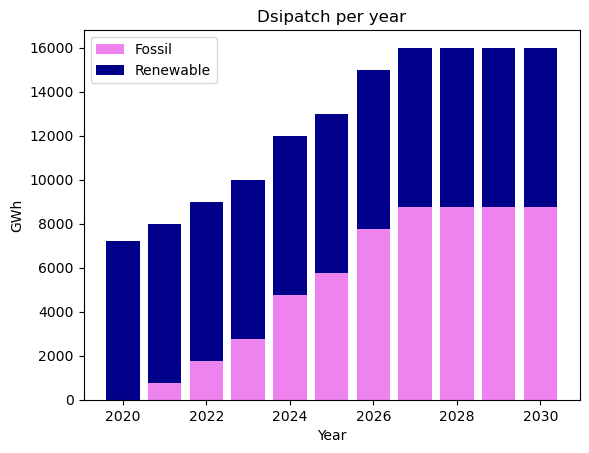

In [84]:
plt.bar(years, fossil_dispatch, color = 'violet', label = 'Fossil')
plt.bar(years, renewable_dispatch, bottom = fossil_dispatch, color = 'darkblue', label = 'Renewable')
plt.title('Dsipatch per year')
plt.xlabel('Year')
plt.ylabel('GWh')
plt.legend()
plt.show()

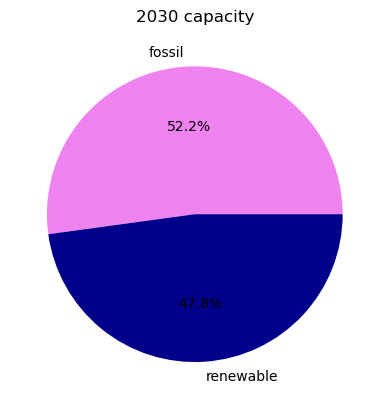

In [86]:
capacity_2030 = [pulp.value(cumulative_capacity[(t,2030)]) for t in technologies]
plt.pie(capacity_2030, labels = technologies, autopct='%1.1f%%', colors = ['violet', 'darkblue'])
plt.title('2030 capacity')
plt.show()